<a href="https://colab.research.google.com/github/noamshimsho/NLP/blob/main/Chapter_3_Transformer_Anatomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers[sentencepiece] datasets

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
text = "time flies like an arrow"


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

# The Encoder

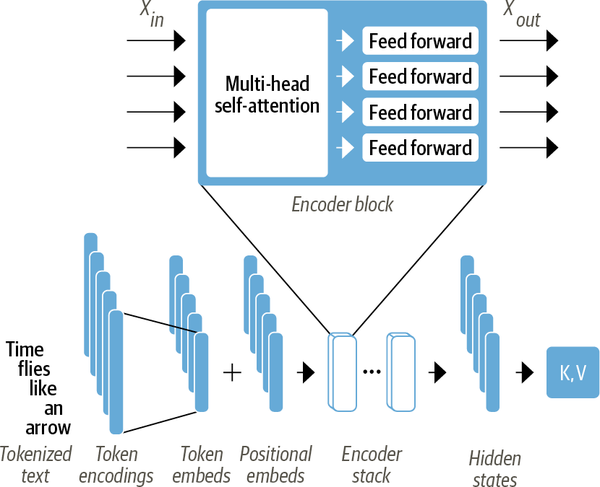

In [ ]:
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=False)
inputs.input_ids

tensor([[ 2051, 10029,  2066,  2019,  8612]])

In [ ]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
token_emb = nn.Embedding(config.vocab_size, config.hidden_size) # torch.nn.Embedding layer that acts as a lookup table for each input ID:
token_emb

Embedding(30522, 768)

In [ ]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size() # [batch_size, seq_len, hidden_dim]

torch.Size([1, 5, 768])

## Self-Attention

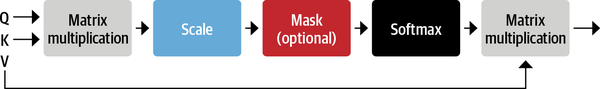

In [ ]:
import torch
from math import sqrt

query = key = value = inputs_embeds
dim_k = key.size(-1)
dim_k, inputs_embeds.shape

(768, torch.Size([1, 5, 768]))

In [ ]:
"""
torch.bmm Batched matrix multiplication

mat1 and mat2 must be 3-D tensors each containing the same number of matrices.

If mat1 is a (b×n×m) tensor, mat2 is a (b×m×p) tensor, out will be a (b×n×p) tensor.
"""
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)  # the attention scores
scores.size(), scores

(torch.Size([1, 5, 5]),
 tensor([[[ 2.5338e+01,  1.7526e+00,  1.3060e+00, -9.8560e-01, -5.7375e-02],
          [ 1.7526e+00,  2.8646e+01,  1.0002e+00,  1.8115e+00,  2.2918e-02],
          [ 1.3060e+00,  1.0002e+00,  3.2240e+01,  7.5046e-01, -2.1616e+00],
          [-9.8560e-01,  1.8115e+00,  7.5046e-01,  2.6267e+01, -7.4313e-01],
          [-5.7375e-02,  2.2918e-02, -2.1616e+00, -7.4313e-01,  3.0238e+01]]],
        grad_fn=<DivBackward0>))

In [ ]:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.size(), weights

(torch.Size([1, 5, 5]),
 tensor([[[1.0000e+00, 5.7121e-11, 3.6545e-11, 3.6948e-12, 9.3480e-12],
          [2.0918e-12, 1.0000e+00, 9.8567e-13, 2.2185e-12, 3.7094e-13],
          [3.6792e-14, 2.7098e-14, 1.0000e+00, 2.1110e-14, 1.1476e-15],
          [1.4594e-12, 2.3929e-11, 8.2821e-12, 1.0000e+00, 1.8599e-12],
          [6.9645e-14, 7.5468e-14, 8.4925e-15, 3.5081e-14, 1.0000e+00]]],
        grad_fn=<SoftmaxBackward0>))

In [ ]:
# The final step is to multiply the attention weights by the values:
attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 5, 768])

In [ ]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value) # [batch_size, num_tokens, head_dim]

In [ ]:
"""
Let’s allow the model to create a different set of vectors for the query, key, and value of a token 
by using three different linear projections to project our initial token vector into three different spaces.
"""

'\nLet’s allow the model to create a different set of vectors for the query, key, and value of a token \nby using three different linear projections to project our initial token vector into three different spaces.\n'

## Multi-headed attention

In [ ]:
"""
It also turns out to be beneficial to have multiple sets of linear projections, each one representing a so-called attention head. 
But why do we need more than one attention head? 
The reason is that the softmax of one head tends to focus on mostly one aspect of similarity. 
Having several heads allows the model to focus on several aspects at once. 
For instance, one head can focus on subject-verb interaction, whereas another finds nearby adjectives. 
Obviously we don’t handcraft these relations into the model, and they are fully learned from the data. 

If you are familiar with computer vision models you might see the resemblance to filters in convolutional neural networks, where one filter can be responsible for detecting faces and another one finds wheels of cars in images.
"""

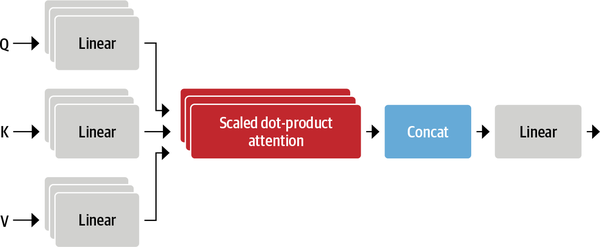

In [ ]:
# SINGLE ATTENTION HEAD

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):  # BERT has 12 attention heads, so the dimension of each head head_dim = 768/12 = 64
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):  # hidden_state =  embedding vectors
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state))
        return attn_outputs

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size  #768
        num_heads = config.num_attention_heads  #12
        head_dim = embed_dim // num_heads  #68   -> Q, K, V dim ALSO THE HEAD OUTPUT SIZE.
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)  # CONCAT THE MultiHeadAttention SCORES.
        x = self.output_linear(x)
        return x  #[batch_size, seq_len, hidden_dim]

In [ ]:
multihead_attn = MultiHeadAttention(config)

inputs_embeds = token_emb(inputs.input_ids)

attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([1, 5, 768])

## The Feed-Forward Layer

In [ ]:
"""
The feed-forward sublayer in the encoder and decoder is just a simple two-layer fully connected neural network, 
but with a twist: instead of processing the whole sequence of embeddings as a single vector, it processes each embedding independently. 

For this reason, this layer is often referred to as a position-wise feed-forward layer. 
A rule of thumb from the literature is for the hidden size of the first layer to be four times the size of the embeddings, and a GELU activation function is most commonly used. 
This is where most of the capacity and memorization is hypothesized to happen, and it’s the part that is most often scaled when scaling up the models. 

We can implement this as a simple nn.Module as follows:
"""

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)  # 768 - 3072
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)  # 3072 - 768
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):  #x.shape = [batch_size, seq_len, hidden_dim]
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x  #x.shape [batch_size, seq_len, hidden_dim]


In [ ]:
"""
Note that a feed-forward layer such as nn.Linear is usually applied to a tensor of shape (batch_size, input_dim), where it acts on each element of the batch dimension independently. 
This is actually true for any dimension except the last one, so when we pass a tensor of shape (batch_size, seq_len, hidden_dim) the layer is applied to all token embeddings of the batch and sequence independently, which is exactly what we want.
"""

In [ ]:
feed_forward = FeedForward(config)
print(attn_outputs.shape)
ff_outputs = feed_forward(attn_outputs)
ff_outputs.size()

torch.Size([1, 5, 768])


torch.Size([1, 5, 768])

## Adding Layer Normalization and skip connection

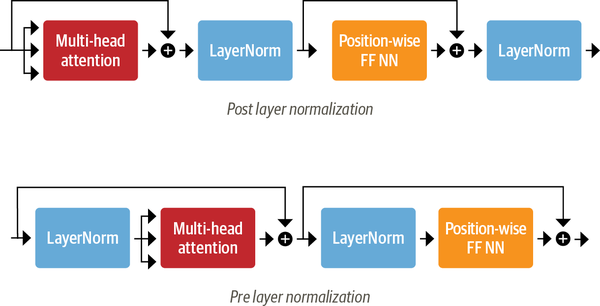

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size) # 2 learnable params, If a single integer is used, module will normalize over the last dimension which is expected to be of that specific size.
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)

    def forward(self, x):  # x = [batch_size, seq_len, embedding_size/hidden_size] 
        # Apply layer normalization and then copy input into query, key, value - Pre Layer Normalization.
        hidden_state = self.layer_norm_1(x)
        # Apply attention with a skip connection
        x = x + self.attention(hidden_state)
        # Apply feed-forward layer with a skip connection
        x = x + self.feed_forward(self.layer_norm_2(x))

        return x # x = [batch_size, seq_len, hidden_size] 



In [ ]:
encoder_layer = TransformerEncoderLayer(config)
print(inputs_embeds.shape, inputs_embeds[0][0][0:10])
output = encoder_layer(inputs_embeds)
print(output.size(), output[0,0,0:10])

torch.Size([1, 5, 768]) tensor([-0.6567,  0.0944, -1.2849, -0.2641, -0.7565, -0.5107, -0.4671, -1.2997,
         0.9576,  0.1616], grad_fn=<SliceBackward0>)
torch.Size([1, 5, 768]) tensor([-0.7473,  0.1387, -1.1080, -0.0454, -0.7463, -0.4735, -0.6842, -1.6673,
         1.1416,  0.1795], grad_fn=<SliceBackward0>)


## Positional Embeddings

In [ ]:
"""
Positional embeddings are based on a simple, yet very effective idea: 
augment the token embeddings with a position-dependent pattern of values arranged in a vector. 

If the pattern is characteristic for each position, the attention heads and feed-forward layers in each stack can learn to incorporate positional information into their transformations.


There are several ways to achieve this, and one of the most popular approaches is to use a learnable pattern, especially when the pretraining dataset is sufficiently large. 
This works exactly the same way as the token embeddings, but using the position index instead of the token ID as input. With that approach, an efficient way of encoding the positions of tokens is learned during pretraining.
"""

In [ ]:
# learnable
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)

        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size) # using the position index instead of the token ID

        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)

        self.dropout = nn.Dropout()

    def forward(self, input_ids): #input_ids = [batch_size, sentence_len]
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [ ]:
embedding_layer = Embeddings(config)
print(inputs.input_ids, inputs.input_ids.shape)
embedding_layer(inputs.input_ids).size()

tensor([[ 2051, 10029,  2066,  2019,  8612]]) torch.Size([1, 5])


torch.Size([1, 5, 768])

In [ ]:
input = torch.LongTensor([[1,20,4,55],[4,333,2,449]])
print(input, input.shape)
embedding_layer(input).size()

tensor([[  1,  20,   4,  55],
        [  4, 333,   2, 449]]) torch.Size([2, 4])


torch.Size([2, 4, 768])

In [ ]:
# full

class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.layers = nn.ModuleList([TransformerEncoderLayer(config)
                                     for _ in range(config.num_hidden_layers)]) # 12

    def forward(self, x):
        x = self.embeddings(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
encoder = TransformerEncoder(config)
print(inputs.input_ids)
encoder(inputs.input_ids).size()

tensor([[ 2051, 10029,  2066,  2019,  8612]])


torch.Size([1, 5, 768])

# Adding a Classification Head

In [ ]:
class TransformerForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = TransformerEncoder(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, x):
        x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [ ]:
config.num_labels = 3
encoder_classifier = TransformerForSequenceClassification(config)
encoder_classifier(inputs.input_ids).size()

torch.Size([1, 3])

# The Decoder

**Masked multi-head self-attention layer**
Ensures that the tokens we generate at each timestep are only based on the past outputs and the current token being predicted. Without this, the decoder could cheat during training by simply copying the target translations; masking the inputs ensures the task is not trivial.

**Encoder-decoder attention layer**
Performs multi-head attention over the output key and value vectors of the encoder stack, with the intermediate representations of the decoder acting as the queries. This way the encoder-decoder attention layer learns how to relate tokens from two different sequences, such as two different languages. The decoder has access to the encoder keys and values in each block.

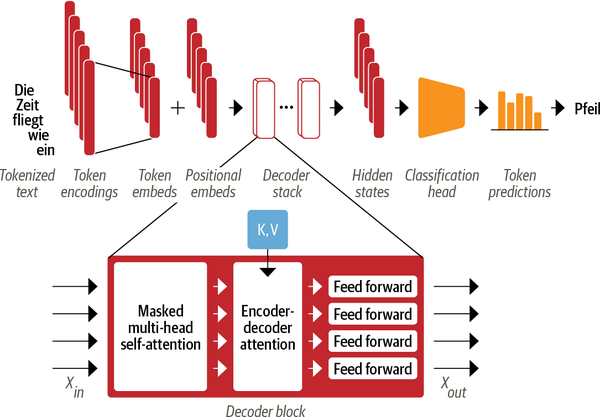

## Masked multi-head self-attention layer

In [ ]:
seq_len = inputs.input_ids.size(-1)
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
mask  # 1X5X5

tensor([[[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]])

In [ ]:
scores = scores.masked_fill(mask == 0, -float("inf"))
scores

tensor([[[ 2.5338e+01,        -inf,        -inf,        -inf,        -inf],
         [ 1.7526e+00,  2.8646e+01,        -inf,        -inf,        -inf],
         [ 1.3060e+00,  1.0002e+00,  3.2240e+01,        -inf,        -inf],
         [-9.8560e-01,  1.8115e+00,  7.5046e-01,  2.6267e+01,        -inf],
         [-5.7375e-02,  2.2918e-02, -2.1616e+00, -7.4313e-01,  3.0238e+01]]],
       grad_fn=<MaskedFillBackward0>)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    weights = F.softmax(scores, dim=-1)
    return weights.bmm(value)

## Encoder-decoder attention layer

# Torch practise

In [ ]:
# nn.Embedding
embedding = nn.Embedding(30000, 768)
input = torch.LongTensor([[1,2050,4,5545],[4,3333,2,449]])
print(input.shape)
embedding(input).size()

torch.Size([2, 4])


torch.Size([2, 4, 768])

In [ ]:
# nn.Linear
m = nn.Linear(20, 30)
input = torch.randn(1,1,1,1,1,1,5, 20)
output = m(input)
output.size()

torch.Size([1, 1, 1, 1, 1, 1, 5, 30])

In [ ]:
# torch.cat
x = torch.randn(2, 3)
y = torch.cat([x, x, x], -1)
y.shape

torch.Size([2, 9])

In [ ]:
# dropout
m = nn.Dropout(p=0.2)
input = torch.randn(2, 5)
output = m(input)
output

tensor([[ 0.0000,  0.4190, -0.0000,  1.2338, -0.0000],
        [ 1.0072, -0.0000,  0.6644, -0.9224,  0.1631]])

In [ ]:
#nn.LayerNorm - Output: same shape as input
# NLP Example
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
# Activate module
print(layer_norm(embedding).shape)

# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.randn(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)
output.shape

torch.Size([20, 5, 10])


torch.Size([20, 5, 10, 10])